In [1]:
import sys
sys.path.append("../getData")
sys.path.append("../../visualization")
sys.path.append("../functions")
import bdStocks
import graficosJupyterNotebook as graficos
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

In [2]:
exchange="MC"
indiceName="ibex35"
getsectors=True
getdescriptions=False
columnas=["netIncome","totalRevenue","stock"]
columnasPrecios=["Adjusted_close","stock"]
not_index=True
tamMinimo=50
mod=4
nivel_confianza=0.05
numberPreds=10

In [3]:
bd=bdStocks.getData()
precios=bd.getPrizesByExchange(exchange,columnas=columnasPrecios)
fundamentals=bd.getFundamentalsByExchange(exchange,bd=True,columnas=columnas)
indice=bd.getIndexPrizes(indiceName)
if getsectors:
    sectors=bd.getSectors(exchange)
    fundamentals["sector"]=fundamentals["stock"].transform(lambda t:sectors[t])
if   getdescriptions:
    descriptions=bd.getDescriptions(exchange)
    fundamentals["description"]=fundamentals["stock"].transform(lambda t:descriptions[t])
if not_index:
    precios.reset_index(inplace=True)
    fundamentals.reset_index(inplace=True)

Time: 03/04/2022, 09:50 Message: CSV access time to get prizes 1.8610570430755615

Time: 03/04/2022, 09:50 Message: Object size (prizes data)63.440014 MB

Time: 03/04/2022, 09:50 Message: BD access time to get stock fundamentals 0.40691280364990234

Time: 03/04/2022, 09:50 Message: Object size (fundamental data)8.026913 MB

Time: 03/04/2022, 09:50 Message: BD access time to sectors 0.06226658821105957



In [4]:
import itertools

sectors=np.unique(fundamentals["sector"])
dataframeAnalysis=fundamentals.loc[fundamentals["sector"].isin([sectors[-6]])]
stocks=[e for e in np.unique(dataframeAnalysis["stock"]) if (dataframeAnalysis.loc[dataframeAnalysis["stock"]==e]).shape[0]>tamMinimo]
print(stocks)
stocks=iter(stocks)
dataframeAnalysis.shape

['ALB', 'BBVA', 'BKT', 'CABK', 'GCO', 'MAP', 'SAN', 'UNI']


(668, 5)

Stock ALB
(75, 1)


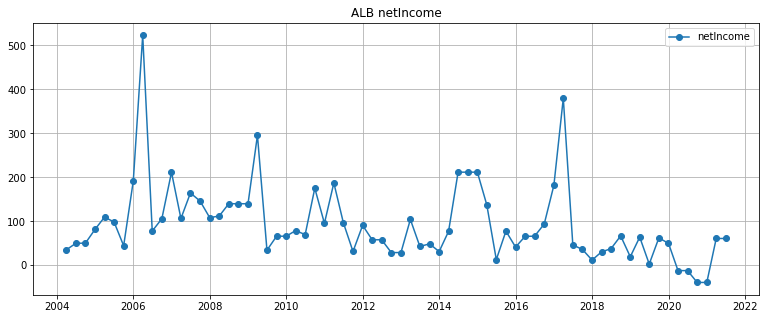

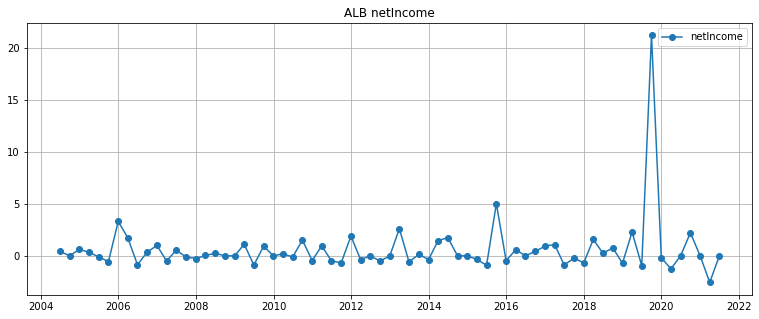

In [5]:
stock=next(stocks)
print("Stock %s"%stock)
column="netIncome"
data=dataframeAnalysis.loc[dataframeAnalysis["stock"]==stock,["fecha",column]]
data.set_index("fecha",inplace=True,drop=True)
print(data.shape)
data=data.fillna(method='ffill')/1000000
data=data.dropna()
graficos.linearplot(data,stock+" "+column,False,column)
graficos.linearplot(data.pct_change(),stock+" "+column,False,column)

-39.05


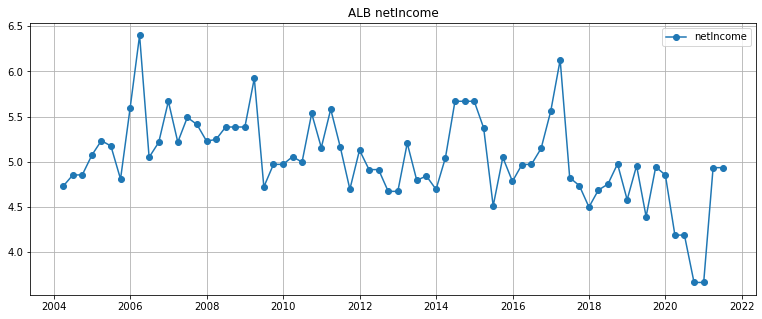

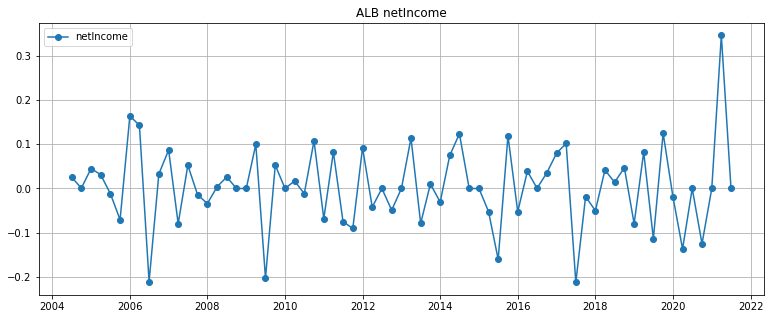

-39.05


In [6]:
import math
import transformations
minimo=np.min(data)[0]
if minimo<0:
    print(minimo)
    data=data-minimo*2
boxcox=transformations.boxcox
data1=(data).applymap(lambda x:(boxcox(0,x)))
graficos.linearplot(data1,stock+" "+column,False,column)
graficos.linearplot(data1.transform(lambda x:x.pct_change()),stock+" "+column,False,column)
print(minimo)
serie=data1[column]


In [7]:
from statsmodels.tsa.stattools import adfuller
#la hipotesis nula es que hay raiz unitaria
adf=adfuller(serie,maxlag=1)
adf

(-4.62666238166495,
 0.00011531617623140897,
 0,
 69,
 {'1%': -3.528889992207215,
  '5%': -2.9044395987933362,
  '10%': -2.589655654274312},
 74.57119252087105)

[ 1.          0.51815131  0.31894014  0.22537376  0.09203049  0.11877494
  0.16403783  0.05914575  0.18019651  0.18218609  0.18790149  0.12662503
  0.06666461 -0.09292964 -0.14916825 -0.11393621 -0.01057828 -0.07036628
 -0.02465448 -0.04506811 -0.00240398  0.01935459 -0.05033187 -0.06665209
 -0.02566304 -0.08496374 -0.03233063 -0.01683642  0.03529829  0.04124303
  0.03866815]
[ 1.          0.52566075  0.07185697  0.0520997  -0.08220791  0.1142055
  0.10917669 -0.11416318  0.22636738  0.03205801  0.10334283 -0.11218656
 -0.00197423 -0.23988369 -0.14160397  0.05083144  0.12992734 -0.18676276
  0.01693639 -0.00644924  0.09912113  0.00240158 -0.08795649  0.13622024
  0.01609886 -0.08695398 -0.00921276  0.02138084  0.12344502 -0.0378485
  0.03790634]


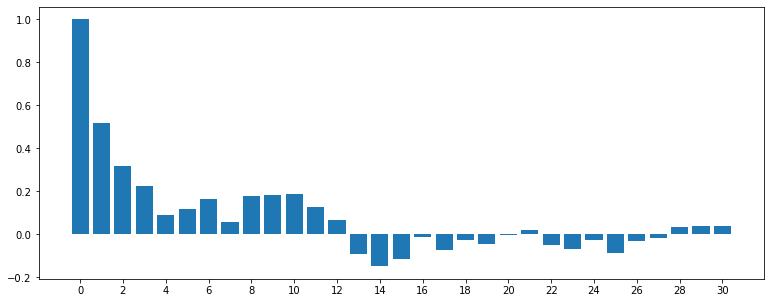

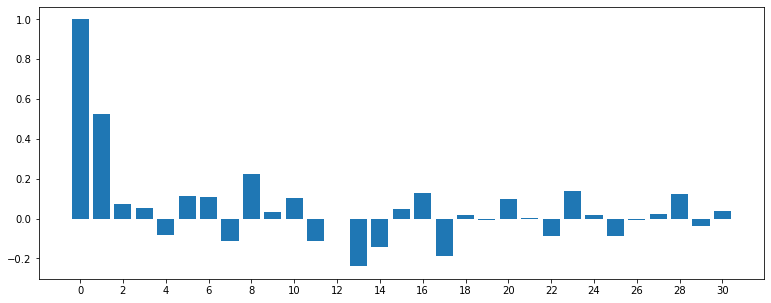

In [8]:
nlags=30
diferenciacion=0
from statsmodels.tsa.stattools import acf
corr=acf(serie,nlags=nlags)
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
pcorr=pacf(serie,nlags=nlags)
print(corr)
print(pcorr)
from  statsmodels.tsa.stattools import arma_order_select_ic  as select_order
modelo=select_order(serie)
graficos.correlograma(corr,pcorr)


In [9]:
print("Autocorrelacion %s"%(np.where(corr>np.mean(corr)+0.25*np.std(corr))[0]))
print("Autocorrelacion  modulo %s %s"%(np.where(corr>np.mean(corr)+0.25*np.std(corr))[0]%mod,mod))
print("Autocorrelacion %s"%(np.where(pcorr>np.mean(pcorr)+0.25*np.std(pcorr))[0]))
print("Autocorrelacion parcial modulo %s %s"%(np.where(pcorr>np.mean(pcorr)+0.25*np.std(pcorr))[0]%mod,mod))

Autocorrelacion [ 0  1  2  3  6  8  9 10]
Autocorrelacion  modulo [0 1 2 3 2 0 1 2] 4
Autocorrelacion [ 0  1  5  8 16 23 28]
Autocorrelacion parcial modulo [0 1 1 0 0 3 0] 4


In [10]:
from scipy.stats import norm
import math
#True es que se acepta y False que se rechaza
def contrasteCoeficientes(corr,pcorr,diferenciacion,nivelConfianza):
    T=len(corr)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivelConfianza/2)
    a= abs(corr)/desv<nivel
    b= abs(pcorr)/desv<nivel
    return a,b
    
    
corrAcept,pcorrAcept=contrasteCoeficientes(corr,pcorr,diferenciacion,0.2)   
print(np.where( corrAcept==False)[0])
print(np.where( pcorrAcept==False)[0])
n=len(np.where( corrAcept==False)[0])
p=n-1
q=len(np.where( pcorrAcept==False)[0])-1
p,q
ordenes=(p,diferenciacion,q)

[0 1 2]
[ 0  1 13]


In [11]:

from statsmodels.tsa.stattools import acovf
from statsmodels.tsa.stattools import acf
from scipy.stats import t
def contrasteMedia0(serie,diferenciacion,nivel_confianza):
    autocorrelaciones=acf(serie)
    T=len(corr)-diferenciacion
    varianzaMuestral=acovf(serie,adjusted=True,fft=False,nlag=len(corr))[0]
  
    varianza=varianzaMuestral/T*np.sum(1+2*autocorrelaciones[1:n])
    
    mediaMuestral=np.mean(serie)
    print(mediaMuestral)
    estadistico=mediaMuestral/varianza
    nivelCritico=t.ppf(1-nivel_confianza/2,T-1)
    print("Estadistico %s"%estadistico)
    print("Nivel critico %s"%nivelCritico)
    return (estadistico<nivelCritico)
    
contrasteMedia0(serie,diferenciacion,nivel_confianza)
contrasteMedia0(serie-np.mean(serie),diferenciacion,nivel_confianza)    



5.033536765625545
Estadistico 191.83598482163046
Nivel critico 2.0422724563012373
-3.2989484160290367e-16
Estadistico -1.2572810088256886e-14
Nivel critico 2.0422724563012373


True

In [12]:
#estimacion de los parametros
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
dataframeModelo=pd.DataFrame(serie)
modelo=ARIMA(endog=dataframeModelo,order=ordenes,trend="c")
#modelo=sm.tsa.statespace.SARIMAX(endog=dataframeModelo,order=ordenes,trend="c")
#modelo=ARMA(endog=dataframeModelo,order=ordenes,freq=dataframeModelo.index.inferred_freq)
dataframeModelo
modeloAjustado=modelo.fit()
modeloAjustado.specification
modeloAjustado.param_terms
modeloAjustado.cov_params()
modeloAjustado.summary()
print("P-Values %s"%(modeloAjustado.pvalues))
print("Shapiro %s"%(scipy.stats.shapiro(modeloAjustado.resid)[1]))
print("LillieFors %s"%(statsmodels.stats.diagnostic.lilliefors(modeloAjustado.resid)[0]))
def contrasteCorrelacionResiduos(serie,diferenciacion,nivelConfianza):
    T=len(serie)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivelConfianza/2)
    a= abs(serie)/desv<nivel
   
    return a

contrasteCorrelacionResiduos(acf(modeloAjustado.resid),diferenciacion,nivel_confianza)

P-Values const     0.000000e+00
ar.L1     8.837611e-01
ar.L2     8.349238e-01
ma.L1     9.400871e-01
ma.L2     6.074538e-01
sigma2    1.497671e-08
dtype: float64
Shapiro 0.7166961431503296
LillieFors 0.07867541842910497


/home/manuel/anaconda3/envs/bolsa/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'
/home/manuel/anaconda3/envs/bolsa/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'
/home/manuel/anaconda3/envs/bolsa/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  warnings.warn('No frequency information was'


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

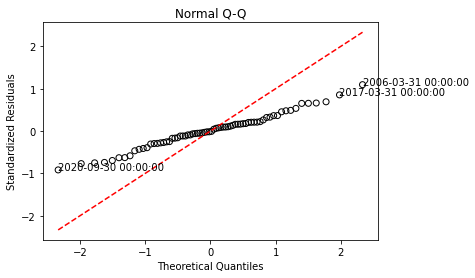

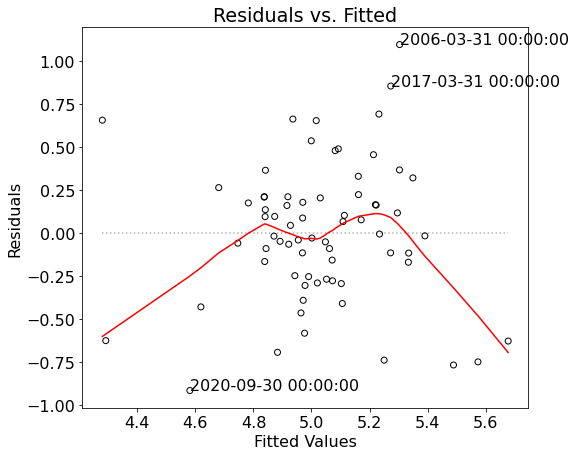

In [13]:
import scipy.stats
import statsmodels.stats.diagnostic
graficos.qqplot(modeloAjustado)
graficos.residualsVSfitted(modeloAjustado)


In [14]:
dataframePred=modeloAjustado.get_forecast(numberPreds).summary_frame()
media=dataframePred.loc[:,"mean"]
mediaInf=dataframePred.loc[:,"mean_ci_lower"]
mediaUpper=dataframePred.loc[:,"mean_ci_upper"]
pred=pd.concat([serie,media],axis=0)[-numberPreds*3:]



In [15]:

ar=modeloAjustado.params["ar.L1"]
ma=modeloAjustado.params["ma.L1"]
const=modeloAjustado.params["const"]
sigma2=modeloAjustado.params["sigma2"]
const*(1-ar)+ ar*(serie[-1]) +ma*modeloAjustado.resid[-1],modeloAjustado.params,modeloAjustado.get_prediction(start=70, dynamic=False).predicted_mean,modeloAjustado.get_forecast(1).summary_frame()


(5.008614831458925,
 const     5.020323
 ar.L1     0.316731
 ar.L2     0.270134
 ma.L1     0.162329
 ma.L2    -0.170333
 sigma2    0.159901
 dtype: float64,
 2021-09-30    4.873849
 Freq: Q-DEC, dtype: float64,
 netIncome       mean   mean_se  mean_ci_lower  mean_ci_upper
 2021-09-30  4.873849  0.399876       4.090106       5.657592)

In [16]:
serie=serie.map(lambda x:(math.exp(x)-minimo))
dataframePred=dataframePred.applymap(lambda x:(math.exp(x)-minimo))

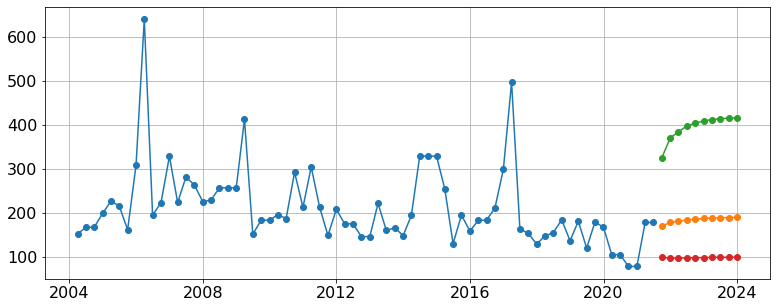

In [17]:

import matplotlib.pyplot as plt
import seaborn
import math
import numpy as np
import matplotlib.dates as mdates
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import scipy.stats as stats
from pydataset import data
graficos.plot_forecast(serie,dataframePred)

In [18]:
dataframePred


netIncome,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-09-30,169.873525,40.541640,98.796247,325.508072
2021-12-31,178.082818,40.607986,97.354214,370.589067
2022-03-31,180.739667,40.625636,97.170821,384.467728
2022-06-30,183.954548,40.637693,97.608076,397.622708
2022-09-30,185.736086,40.642627,97.968613,404.245422
2022-12-31,187.200090,40.645305,98.361049,409.106667
2023-03-31,188.158208,40.646552,98.653273,412.070754
2023-06-30,188.864334,40.647184,98.889078,414.128217
2023-09-30,189.350186,40.647490,99.060590,415.485994
2023-12-31,189.696537,40.647642,99.187656,416.423859


In [19]:
dataframePred.iloc[0,0]-math.sqrt(modeloAjustado.params["sigma2"])*norm.ppf(1-nivel_confianza/2)

169.0897819559958